# **Installing Required Libraries**

In [2]:
# !pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

In [3]:
import os

GOOGLE_API_KEY = "GOOGLE_API_KEY"  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [4]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

In [5]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


****

In [6]:
from pathlib import Path

input_image_path = Path("restaurants_data")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

# **Define the Pydantic Class for the Structured Parser**

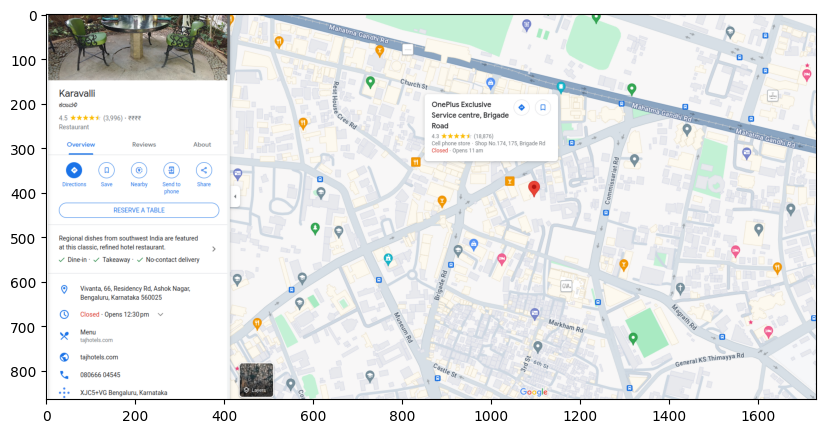

In [23]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "./restaurants_data/Karavalli.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

# **Call the Pydantic Program and Generate Structured Output**

In [9]:
from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

In [ ]:
/content/restaurants_data

## **Generate the Pydantic Structured Output via Gemini Vision Model**

In [10]:
from llama_index import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./restaurants_data"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

# **Build Multi-Modal RAG for Restaurant Recommendation**

In [11]:
from llama_index.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

**Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store**

In [12]:
from llama_index import VectorStoreIndex, StorageContext, ServiceContext
from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
from llama_index.vector_stores import QdrantVectorStore
from llama_index import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY), embed_model=embed_model
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    service_context=service_context,
    storage_context=storage_context,
)

# **Using Gemini to synthesize the results and recommend the restaurants to user**

In [19]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a good dining restaurant for me and its nearby visting places"
)
print(response)

Karavalli, located at Vivanta, 66, Residency Road, Ashok Nagar, Bengaluru, Karnataka 560025, is a highly-rated restaurant serving regional dishes from southwest India. It offers a refined dining experience with a price range of ₹1,000 - ₹2,000. Nearby, you can visit the OnePlus Exclusive Service Centre and Brigade Road.
